### Student Number - Surname: [First Student Number] - [Enter Surname First Student Here]

# Question 1 [40]
## Consider a bar that is clamped at $x_1=0$ and loaded by a force $F=10 000$ N (in the positive x-direction) at the right edge $x_1=0.5$.
## The area of the bar changes with $x_1$ and is given by $A(x_1) = 0.0001x_1 + 0.0001\;m^2$.
## The bar has a Young's modulus of $E=210$ GPa.
### 1. Solve the weak form for the 1D bar problem using one quadratic finite element. [20]
### 2. Determine whether the approximated solution satisfies equilibrium. [5]
### 3. Plot the displacement over the structure. [5]
### 4. Plot the original and deformed structures. [5]
### 5. Plot the approximated stress over the structure and compare it against the actual stress $\sigma_{11}(\mathbf{x}) = \frac{F}{A(x_1)}$. [5]
### 6. From the approximated stress field compute the internal force as a function of $x_1$ and compare it against the expected internal force. [5]

In [3]:
# Question 1 - Solving the Problem
import numpy as np

def N1(z):
    return -0.5*z*(1-z)

def N2(z):
    return 0.5*z*(1+z)

def N3(z):
    return (1+z)*(1-z)

def dN1(z):
    return -0.5+z

def dN2(z):
    return 0.5+z

def dN3(z):
    return -2*z

def DN(z):
    return np.array([dN1(z),dN2(z),dN3(z)])

def N(z):
    return np.array([N1(z),N2(z),N3(z)])

def x(z,xcoords):
    return N1(z)*xcoords[0] + N2(z)*xcoords[2] + N3(z)*xcoords[1]

def dx(z,xcoords):
    xcoords_dash = np.array([xcoords[0],xcoords[2],xcoords[1]])
    return np.dot(DN(z),xcoords_dash)

def B(z,xcoords):
    return 1/dx(z,xcoords)*DN(z)

def A(x):
    return 0.0001+0.0001*x

def E(x):
    return 210E9

def K_integrand(z,xcoords):
    xvalue = x(z,xcoords)
    Ki = np.outer(B(z,xcoords),B(z,xcoords))*A(xvalue)*E(xvalue)*dx(z,xcoords)
    return Ki

def Gauss(xcoords,number_of_points):
    if number_of_points == 2:
        zvalues = np.array([-1/3**0.5,1/3**0.5])
        weights = np.array([1,1])
    K = np.zeros((3,3))
    for i in range(len(zvalues)):
        K = K + weights[i]*K_integrand(zvalues[i],xcoords)
    return K

def assemble_element(Kglobal,element_nodes,Klocal):
    elementnd = [element_nodes[0],element_nodes[2],element_nodes[1]]
    for i in range(len(element_nodes)):
        for j in range(len(element_nodes)):
            Kglobal[elementnd[i],elementnd[j]] = Kglobal[elementnd[i],elementnd[j]] + Klocal[i,j]
    return Kglobal

def assemble_traction(Fglobal,element_nodes,Flocal):
    elementnd = [element_nodes[0],element_nodes[2],element_nodes[1]]
    for i in range(len(element_nodes)):
        Fglobal[elementnd[i]] = Fglobal[elementnd[i]] + Flocal[i]
    return Fglobal

def Flocal(z,t,xcoords):
    xvalue = x(z,xcoords)
    F = t*A(xvalue)
    return N(z)*F

def PartitionKglobal(Kglobal,known_nodes,unknown_nodes):
    u = len(unknown_nodes)
    k = len(known_nodes)
    Kuu = np.zeros((u,u))
    Kuk = np.zeros((u,k))
    Kkk = np.zeros((k,k))
    Kku = np.zeros((k,u))

    for i in range(u):
        for j in range(u):
            Kuu[i,j] = Kglobal[unknown_nodes[i],unknown_nodes[j]]

    for i in range(u):
        for j in range(k):
            Kuk[i,j] = Kglobal[unknown_nodes[i],known_nodes[j]]
            
    for i in range(k):
        for j in range(k):
            Kkk[i,j] = Kglobal[known_nodes[i],known_nodes[j]]


    for i in range(k):
        for j in range(u):
            Kku[i,j] = Kglobal[known_nodes[i],unknown_nodes[j]]
    
    return Kuu, Kuk, Kkk, Kku

def PartitionFglobal(Fglobal,known_nodes,unknown_nodes):
    u = len(unknown_nodes)
    k = len(known_nodes)
    Fu = np.zeros((u,1))
    Fk = np.zeros((k,1))
    
    for i in range(u):
        Fu[i,0] = Fu[i,0] + Fglobal[unknown_nodes[i]]
        
    for i in range(k):
        Fk[i,0] = Fk[i,0] + Fglobal[known_nodes[i]]
    return Fu, Fk

def AssembleU(uk,uu,nk,nu):
    rk,c = uk.shape
    ru,c = uu.shape    
    u = np.zeros((rk+ru,1))
    n = list(nk) + (nu)
    for i in range(rk):
        u[i,0] = uk[i]
    for i in range(ru):
        u[rk+i,0] = uu[i]
    return u, n

xcoords = [0, 0.25, 0.5]
Kglobal = np.zeros((3,3))
element_nodes = [0,1,2]

Kglobal = assemble_element(Kglobal,element_nodes,Gauss(xcoords,2))
print('Global Stiffness Matrix:')
print(Kglobal)

Fglobal = np.zeros(3)
xvalue = xcoords[-1]
t1 = 10000/A(xvalue)
Tl = Flocal(1,t1,xcoords)

Fglobal = assemble_traction(Fglobal,element_nodes,Tl)
print('Global Load Vector  {}'.format(Fglobal))

known_nodes = [0]
unknown_nodes = [1,2]
uk = np.array([[0]])

Kuu,Kuk,Kkk,Kku = PartitionKglobal(Kglobal,known_nodes,unknown_nodes)
Fu, Fk = PartitionFglobal(Fglobal,known_nodes,unknown_nodes)

uu = np.linalg.solve(Kuu,-Kuk*uk + Fu)
u,nodes = AssembleU(uk,uu,known_nodes,unknown_nodes)
print('Total nodal displacement {}'.format(u))

Global Stiffness Matrix:
[[ 1.085e+08 -1.260e+08  1.750e+07]
 [-1.260e+08  2.800e+08 -1.540e+08]
 [ 1.750e+07 -1.540e+08  1.365e+08]]
Global Load Vector  [    0.     0. 10000.]
Total nodal displacement [[0.        ]
 [0.00010618]
 [0.00019305]]


Question 2 - Equilibrium - Multiple Ways to Answer The Question

Only non-zero stress term is sigma_xx! Hence when we write equilibrium 
we see that to satisfy equilibrium:
d sigma_xx / dx  = 0 
Only true if sigma_xx is constant. Interrogate solution and see sigma_xx is not constant i.e. does not satisfy equilbrium.

Alternative - compute the internal reaction force and if it changes between two points it cannot be in equilibrium, see plot below for Force over x which is not constant.

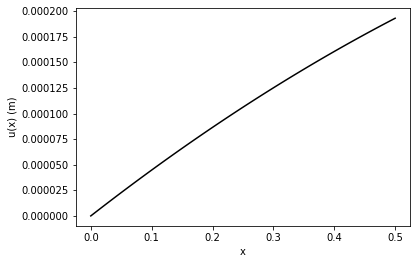

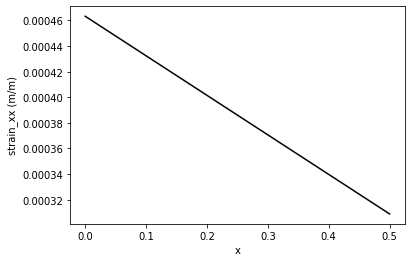

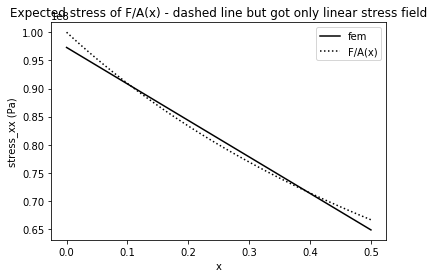

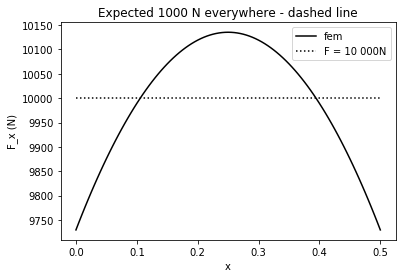

Interpret result and ensure you understand why it makes sense
Left edge high stress -> smallest area
Force variation around 10000 is about 400 i.e.  9750 - 10150
Solution is approximate


In [4]:
# Question 3 - Plotting the Solution

# Only now can we construct the displacement field, since we have solved for the unknowns
def ufield(z,ucoords):
    return N1(z)*ucoords[0] + N2(z)*ucoords[2] + N3(z)*ucoords[1]

def strainfield(z,xcoords,ucoords):
    ucoords_prime = [ucoords[0],ucoords[2],ucoords[1]]
    stress = np.dot(B(z,xcoords),ucoords_prime)
    return stress

def stressfield(z,xcoords,ucoords):
    ucoords_prime = [ucoords[0],ucoords[2],ucoords[1]]
    stress = E(x(xi,xcoords))*np.dot(B(z,xcoords),ucoords_prime)
    return stress

# Discretize in local coordinates to plot fields
xi = np.linspace(-1,1,101)

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(x(xi,xcoords),ufield(xi,u),'k-')
plt.xlabel('x')
plt.ylabel('u(x) (m)')
plt.show()

plt.figure(2)
strain = []
for XI in xi:
    strain.append(strainfield(XI,xcoords,u))
strain = np.array(strain)

plt.plot(x(xi,xcoords),strain,'k-')
plt.xlabel('x')
plt.ylabel('strain_xx (m/m)')


plt.figure(3)
stress = []
for XI in xi:
    stress.append(stressfield(XI,xcoords,u))
stress = np.array(stress)

plt.plot(x(xi,xcoords),stress,'k-',label='fem')
plt.plot(x(xi,xcoords),10000.0/A(x(xi,xcoords)),'k:',label='F/A(x)')
plt.xlabel('x')
plt.ylabel('stress_xx (Pa)')
plt.legend(loc='best')
plt.title('Expected stress of F/A(x) - dashed line but got only linear stress field')
plt.show()

plt.figure(4)
force = []
for XI in xi:
    force.append(stressfield(XI,xcoords,u)*A(x(XI,xcoords)))
force = np.array(force)

plt.plot(x(xi,xcoords),force,'k-',label='fem')
plt.plot(x(xi,xcoords),10000.0*np.ones(xi.shape),'k:',label='F = 10 000N')
plt.xlabel('x')
plt.ylabel('F_x (N)')
plt.legend(loc='best')
plt.title('Expected 1000 N everywhere - dashed line')
plt.show()

print('Interpret result and ensure you understand why it makes sense')
print('Left edge high stress -> smallest area')
print('Force variation around 10000 is about 400 i.e.  9750 - 10150')
print('Solution is approximate')

# Question 2 [40]

## Consider a bar that is clamped at $x_1=0$ and loaded by a force $F=10 000$ N (in the positive x-direction) at the right edge $x_1=0.5$.
## The area of the bar changes with $x_1$ and is given by $A(x_1) = 0.0001x_1 + 0.0001\;m^2$.
## The bar has a Young's modulus of $E=210$ GPa.
### 1. Solve the weak form for the 1D bar problem using two quadratic finite elements. [20]

### 2. Determine whether the approximated solution satisfies equilibrium. [5]
### 3. Plot the displacement over the structure. [5]
### 4. Plot the original and deformed structures. [5]
### 5. Plot the approximated stress over the structure and compare it against the actual stress $\sigma_{11}(\mathbf{x}) = \frac{F}{A(x_1)}$. [5]
### 6. From the approximated stress field compute the internal force as a function of $x_1$ and compare it against the expected internal force. [5]

In [5]:
# Question 3 - Solving the Problem Two Elements Reusing Previously Written Functions
import numpy as np

def N1(z):
    return -0.5*z*(1-z)

def N2(z):
    return 0.5*z*(1+z)

def N3(z):
    return (1+z)*(1-z)

def dN1(z):
    return -0.5+z

def dN2(z):
    return 0.5+z

def dN3(z):
    return -2*z

def DN(z):
    return np.array([dN1(z),dN2(z),dN3(z)])

def N(z):
    return np.array([N1(z),N2(z),N3(z)])

def x(z,xcoords):
    return N1(z)*xcoords[0] + N2(z)*xcoords[2] + N3(z)*xcoords[1]

def dx(z,xcoords):
    xcoords_dash = np.array([xcoords[0],xcoords[2],xcoords[1]])
    return np.dot(DN(z),xcoords_dash)

def B(z,xcoords):
    return 1/dx(z,xcoords)*DN(z)

def A(x):
    return 0.0001+0.0001*x

def E(x):
    return 210E9

def K_integrand(z,xcoords):
    xvalue = x(z,xcoords)
    Ki = np.outer(B(z,xcoords),B(z,xcoords))*A(xvalue)*E(xvalue)*dx(z,xcoords)
    return Ki

def Gauss(xcoords,number_of_points):
    if number_of_points == 2:
        zvalues = np.array([-1/3**0.5,1/3**0.5])
        weights = np.array([1,1])
    K = np.zeros((3,3))
    for i in range(len(zvalues)):
        K = K + weights[i]*K_integrand(zvalues[i],xcoords)
    return K

def assemble_element(Kglobal,element_nodes,Klocal):
    elementnd = [element_nodes[0],element_nodes[2],element_nodes[1]]
    for i in range(len(element_nodes)):
        for j in range(len(element_nodes)):
            Kglobal[elementnd[i],elementnd[j]] = Kglobal[elementnd[i],elementnd[j]] + Klocal[i,j]
    return Kglobal

def assemble_traction(Fglobal,element_nodes,Flocal):
    elementnd = [element_nodes[0],element_nodes[2],element_nodes[1]]
    for i in range(len(element_nodes)):
        Fglobal[elementnd[i]] = Fglobal[elementnd[i]] + Flocal[i]
    return Fglobal

def Flocal(z,t,xcoords):
    xvalue = x(z,xcoords)
    F = t*A(xvalue)
    return N(z)*F

def PartitionKglobal(Kglobal,known_nodes,unknown_nodes):
    u = len(unknown_nodes)
    k = len(known_nodes)
    Kuu = np.zeros((u,u))
    Kuk = np.zeros((u,k))
    Kkk = np.zeros((k,k))
    Kku = np.zeros((k,u)1,2)

    for i in range(u):
        for j in range(u):
            Kuu[i,j] = Kglobal[unknown_nodes[i],unknown_nodes[j]]

    for i in range(u):
        for j in range(k):
            Kuk[i,j] = Kglobal[unknown_nodes[i],known_nodes[j]]
            
    for i in range(k):
        for j in range(k):
            Kkk[i,j] = Kglobal[known_nodes[i],known_nodes[j]]


    for i in range(k):
        for j in range(u):
            Kku[i,j] = Kglobal[known_nodes[i],unknown_nodes[j]]
    
    return Kuu, Kuk, Kkk, Kku

def PartitionFglobal(Fglobal,known_nodes,unknown_nodes):
    u = len(unknown_nodes)
    k = len(known_nodes)
    Fu = np.zeros((u,1))
    Fk = np.zeros((k,1))
    
    for i in range(u):
        Fu[i,0] = Fu[i,0] + Fglobal[unknown_nodes[i]]
        
    for i in range(k):
        Fk[i,0] = Fk[i,0] + Fglobal[known_nodes[i]]
    return Fu, Fk

def AssembleU(uk,uu,nk,nu):
    rk,c = uk.shape
    ru,c = uu.shape    
    u = np.zeros((rk+ru,1))
    n = list(nk) + (nu)
    for i in range(rk):
        u[i,0] = uk[i]
    for i in range(ru):
        u[rk+i,0] = uu[i]
    return u, n

# Everything above is exactly the same as before - just include to reload all functions after running
# previous assignments solution - Run 1 Element Solution to Reload Functions

xcoords = np.array([0, 0.125, 0.25, 0.375, 0.5])
Kglobal = np.zeros((5,5))
element_nodes_matrix = [[0,1,2],[2,3,4]]

for element_nodes in element_nodes_matrix:
    xcoords_elem = xcoords[element_nodes[0]:element_nodes[2]+1]
    print(xcoords_elem)
    Kglobal = assemble_element(Kglobal,element_nodes,Gauss(xcoords_elem,2))
print('Global Stiffness Matrix:')
print(Kglobal)

Fglobal = np.zeros(5)
xvalue = xcoords[-1]
t1 = 10000/A(xvalue)
Tl = Flocal(1,t1,xcoords[element_nodes_matrix[1][0]:element_nodes_matrix[1][2]+1])

element_nodes = element_nodes_matrix[1] # Element that has the traction
Fglobal = assemble_traction(Fglobal,element_nodes,Tl)
print('Global Load Vector  {}'.format(Fglobal))

known_nodes = [0]
unknown_nodes = [1,2,3,4]
uk = np.array([[0]])

Kuu,Kuk,Kkk,Kku = PartitionKglobal(Kglobal,known_nodes,unknown_nodes)
Fu, Fk = PartitionFglobal(Fglobal,known_nodes,unknown_nodes)

uu = np.linalg.solve(Kuu,-Kuk*uk + Fu)
u,nodes = AssembleU(uk,uu,known_nodes,unknown_nodes)

print('Total nodal displacement {}'.format(u))

[0.    0.125 0.25 ]
[0.25  0.375 0.5  ]
Global Stiffness Matrix:
[[ 2.065e+08 -2.380e+08  3.150e+07  0.000e+00  0.000e+00]
 [-2.380e+08  5.040e+08 -2.660e+08  0.000e+00  0.000e+00]
 [ 3.150e+07 -2.660e+08  4.900e+08 -2.940e+08  3.850e+07]
 [ 0.000e+00  0.000e+00 -2.940e+08  6.160e+08 -3.220e+08]
 [ 0.000e+00  0.000e+00  3.850e+07 -3.220e+08  2.835e+08]]
Global Load Vector  [    0.     0.     0.     0. 10000.]
Total nodal displacement [[0.00000000e+00]
 [5.60802834e-05]
 [1.06257379e-04]
 [1.51640173e-04]
 [1.93076637e-04]]


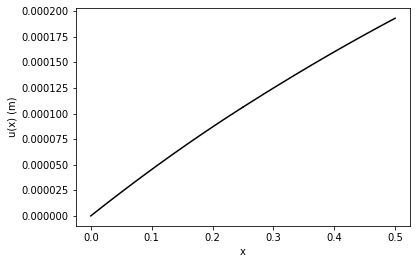

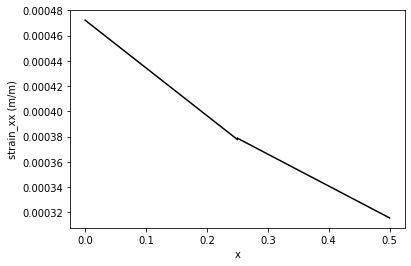

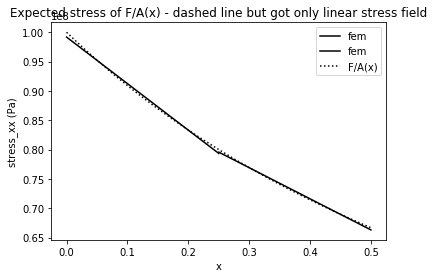

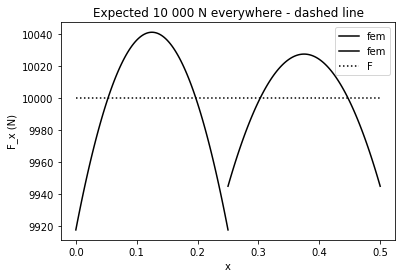

Interpret result and ensure you understand why it makes sense
Left edge high stress -> smallest area
Force variation around 10 000N has decreased from 400 to 120 i.e.  9920 - 10040
Two elements more accurate than 1 element


In [6]:
# Question 2 - Plotting the Solution

# Only now can we construct the displacement field, since we have solved for the unknowns
def ufield(z,ucoords):
    return N1(z)*ucoords[0] + N2(z)*ucoords[2] + N3(z)*ucoords[1]

def strainfield(z,xcoords,ucoords):
    ucoords_prime = [ucoords[0],ucoords[2],ucoords[1]]
    stress = np.dot(B(z,xcoords),ucoords_prime)
    return stress

def stressfield(z,xcoords,ucoords):
    ucoords_prime = [ucoords[0],ucoords[2],ucoords[1]]
    stress = E(x(xi,xcoords))*np.dot(B(z,xcoords),ucoords_prime)
    return stress

# Discretize in local coordinates to plot fields
xi = np.linspace(-1,1,101)

import matplotlib.pyplot as plt

plt.figure(1)
for element_nodes in element_nodes_matrix:
    xcoords_elem = xcoords[element_nodes[0]:element_nodes[2]+1]
    u_elem = u[element_nodes[0]:element_nodes[2]+1]
    plt.plot(x(xi,xcoords_elem),ufield(xi,u_elem),'k-')
    
plt.xlabel('x')
plt.ylabel('u(x) (m)')
plt.show()

plt.figure(2)

for element_nodes in element_nodes_matrix:
    xcoords_elem = xcoords[element_nodes[0]:element_nodes[2]+1]
    u_elem = u[element_nodes[0]:element_nodes[2]+1]

    strain = []
    for XI in xi:
        strain.append(strainfield(XI,xcoords_elem,u_elem))
    strain = np.array(strain)

    plt.plot(x(xi,xcoords_elem),strain,'k-')
    
plt.xlabel('x')
plt.ylabel('strain_xx (m/m)')


plt.figure(3)
for element_nodes in element_nodes_matrix:
    xcoords_elem = xcoords[element_nodes[0]:element_nodes[2]+1]
    u_elem = u[element_nodes[0]:element_nodes[2]+1]

    stress = []
    for XI in xi:
        stress.append(stressfield(XI,xcoords_elem,u_elem))
    stress = np.array(stress)

    plt.plot(x(xi,xcoords_elem),stress,'k-',label='fem')

plt.plot(x(xi,[0,0.25,0.5]),10000.0/A(x(xi,[0,0.25,0.5])),'k:',label='F/A(x)')
plt.xlabel('x')
plt.ylabel('stress_xx (Pa)')
plt.legend(loc='best')
plt.title('Expected stress of F/A(x) - dashed line but got only linear stress field')
plt.show()

plt.figure(4)
for element_nodes in element_nodes_matrix:
    xcoords_elem = xcoords[element_nodes[0]:element_nodes[2]+1]
    u_elem = u[element_nodes[0]:element_nodes[2]+1]

    force = []
    for XI in xi:
        force.append(stressfield(XI,xcoords_elem,u_elem)*A(x(XI,xcoords_elem)))
    force = np.array(force)

    plt.plot(x(xi,xcoords_elem),force,'k-',label='fem')

plt.plot(x(xi,[0,0.25,0.5]),10000.0*np.ones(xi.shape),'k:',label='F')
plt.xlabel('x')
plt.ylabel('F_x (N)')
plt.legend(loc='best')
plt.title('Expected 10 000 N everywhere - dashed line')
plt.show()

print('Interpret result and ensure you understand why it makes sense')
print('Left edge high stress -> smallest area')
print('Force variation around 10 000N has decreased from 400 to 120 i.e.  9920 - 10040')
print('Two elements more accurate than 1 element')

# Question 3 [40]

## Consider a bar that is clamped at $x_1=0$ and loaded by a force $F=10 000$ N (in the positive x-direction) at the right edge $x_1=0.5$.
## The area of the bar changes with $x_1$ and is given by $A(x_1) = 0.0001x_1 + 0.0001\;m^2$.
## The bar has a Young's modulus of $E=210$ GPa.
### 1. Solve the weak form for the 1D bar problem using 10-100 quadratic finite elements. [20]

### 2. Determine whether the approximated solution satisfies equilibrium. [5]
### 3. Plot the displacement over the structure. [5]
### 4. Plot the original and deformed structures. [5]
### 5. Plot the approximated stress over the structure and compare it against the actual stress $\sigma_{11}(\mathbf{x}) = \frac{F}{A(x_1)}$. [5]
### 6. From the approximated stress field compute the internal force as a function of $x_1$ and compare it against the expected internal force. [5]

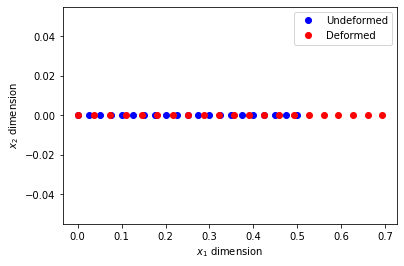

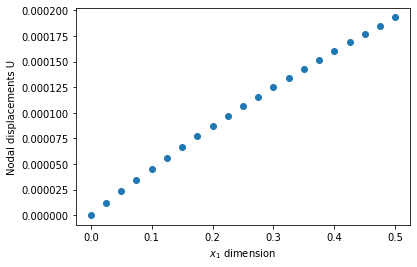

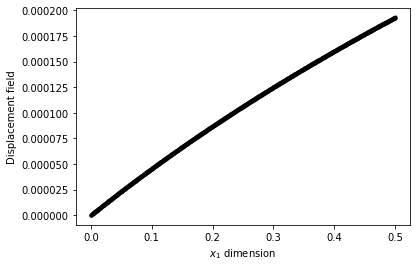

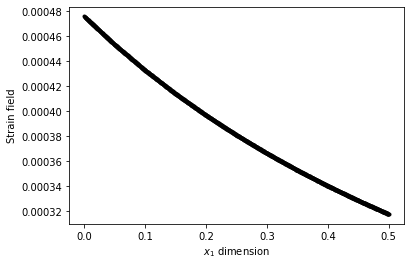

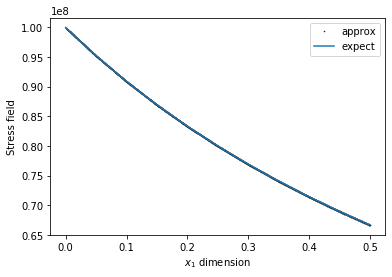

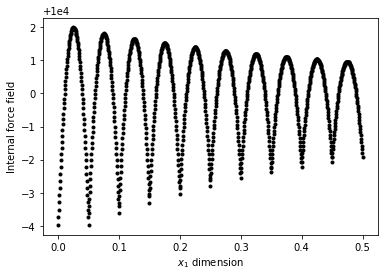

In [14]:
# Select the number of elements: 10, 100
no_elements = 10

import numpy as np

def C(xi,local_coords):
    C_val = 210e9
    return C_val

def N1(xi):
    N_1 = -0.5*xi*(1-xi)
    return N_1

def N2(xi):
    N_2 = 0.5*xi*(1+xi)
    return N_2

def N3(xi):
    N_3 = (1-xi)*(1+xi)
    return N_3

def N1(xi):
    N_1 = -0.5*xi*(1-xi)
    return N_1

def N2(xi):
    N_2 = 0.5*xi*(1+xi)
    return N_2

def N3(xi):
    N_3 = (1-xi)*(1+xi)
    return N_3

def dN1(xi):
    dN_1 = xi-0.5
    return dN_1

def dN2(xi):
    dN_2 = xi + 0.5
    return dN_2

def dN3(xi):
    dN_3 = -2*xi
    return dN_3

def x(xi,loc_coords):
    x_xi = N1(xi)*loc_coords[0,0] + N2(xi)*loc_coords[0,1] + N3(xi)*loc_coords[0,2]
    return x_xi 

def u(xi,q):
    u_xi = N1(xi)*q[0,0] + N2(xi)*q[0,1] + N3(xi)*q[0,2]
    return u_xi 

def dN(z):
    dN_vec = np.array([[dN1(z),dN2(z),dN3(z)]])
    return dN_vec

def dxdxi(xi,local_coords):
    dxdz_val = np.dot(dN(xi),local_coords.T)
    return dxdz_val

def B(xi,local_coords):
    B_vec = 1/dxdxi(xi,local_coords)*dN(xi)
    return B_vec

def A(xi,local_coords):
    A_val = 0.0001 + 0.0001*x(xi,local_coords)
    return A_val

import numpy as np
import sympy as sp

def K_term(xi,local_coords):
    term = B(xi,local_coords)*C(xi,local_coords)*B(xi,local_coords).T*A(xi,local_coords)*dxdxi(xi,local_coords)
    return term

import numpy as np
import sympy as sp

values = np.array([[0,0,0,0,0],[-1/np.sqrt(3),1/np.sqrt(3),0,0,0],[-3409/4401,0,3409/4401,0,0],
                  [-4744/5509,-8609/25322,8609/25322,4744/5509,0],
                  [-7669/8463,-5333/9904,0,5333/9904,7669/8463]])
weights = np.array([[2,0,0,0,0],[1,1,0,0,0],[5/9,8/9,5/9,0,0],
                   [3681/10582,6901/10582,6901/10582,3681/10582,0],
                   [956/4035,1075/2246,128/225,1075/2246,956/4035]])


def K_local_func(local_node_coordinates):
    sum_t = np.zeros((3,3))
    gaussian_quadrature_pts = 3
    g_ind = gaussian_quadrature_pts - 1

    for i in range(gaussian_quadrature_pts):
        sum_t = sum_t + weights[g_ind,i]*K_term(values[g_ind,i],local_node_coordinates)
        
    K_local = sum_t
    return K_local

def K_assemble(K_global,K_local,local_inds,element_no):
    for j in range(3):
            j_global = element_no*2 + j
            for k in range(3):
                k_global = element_no*2 + k
                K_global[j_global,k_global] = K_global[j_global,k_global] + K_local[local_inds[j],local_inds[k]]
    
    return K_global

import numpy as np
import sympy as sp

def K_global_func(no_elements,global_node_coordinates):
    
    no_nodes = np.max(np.shape(global_node_coordinates))
    
    K_global = np.zeros((no_nodes,no_nodes))
    local_inds = np.array([0,2,1])
    
    for e in range(no_elements):
        coords = global_node_coordinates[e*2:e*2+3]
        local_node_coordinates = np.array([coords[local_inds]])        
        K_local = K_local_func(local_node_coordinates)
        K_global = K_assemble(K_global,K_local,local_inds,e)
                
    return K_global

import numpy as np
import sympy as sp

def problem_def_solveU(no_elements,global_node_coordinates):
    F = 10000
    
    # loadings info
    A_end = 0.0001 + 0.0001*global_node_coordinates[-1]
    t1 = F/(A_end)

    no_nodes = np.max(np.shape(global_node_coordinates))
   #pts = gaussian_quadrature_pts - 1
    
    K_global = K_global_func(no_elements,global_node_coordinates)
    
    F_global = np.zeros((no_nodes,1))
    U_global = np.zeros((no_nodes,1))
    
    U_global[0] = 0
    F_global[no_nodes-1] = t1*A_end
    
    Kpp = K_global[0,0]
    Kfp = K_global[0,1:no_nodes]
    Kff = K_global[1:no_nodes,1:no_nodes]

    Fp = F_global[1:no_nodes,0] - Kfp*U_global[1:no_nodes,0]

    Uf = np.linalg.solve(Kff,Fp)
    U_global[1:no_nodes,0] = Uf[:]
    return U_global

def element_fields(res_per_element,local_coords,q):
    
    el_epsilon_field = np.zeros((res_per_element,1))
    el_sigma_field = np.zeros((res_per_element,1))
    el_disp_field = np.zeros((res_per_element,1))
    el_field_coords = np.zeros((res_per_element,1))
    
    xis = np.linspace(-1,1,res_per_element)
    for pt in range(res_per_element):
        xi = xis[pt]
        el_eps = np.dot(B(xi,local_coords),q.T)
        el_epsilon_field[pt,0] = el_eps
        el_sigma_field[pt,0] = el_eps*C(xi,local_coords)
        el_disp_field[pt,0] = u(xi,q)
        el_field_coords[pt,0] = x(xi,local_coords)
        
    return el_epsilon_field, el_sigma_field, el_disp_field, el_field_coords


def global_fields(U_global,res_per_element,no_elements,global_node_coordinates):
    
    epsilon_field = np.zeros((no_elements*res_per_element,1))
    sigma_field = np.zeros((no_elements*res_per_element,1))
    disp_field = np.zeros((no_elements*res_per_element,1))
    field_coords = np.zeros((no_elements*res_per_element,1))
    
    for e in range(no_elements):
        
        local_inds = np.array([0,2,1])
        coords = global_node_coordinates[e*2:e*2+3]
        local_coords = np.array([coords[local_inds]])
        
        q_st = np.array([U_global[e*2:e*2+3,0]])
        q = np.array([q_st[0,local_inds]])
        el_epsilon_field, el_sigma_field, el_disp_field, el_field_coords = element_fields(res_per_element,local_coords,q)
        
        epsilon_field[e*res_per_element:(e+1)*res_per_element,0] = el_epsilon_field[:,0]
        sigma_field[e*res_per_element:(e+1)*res_per_element,0] = el_sigma_field[:,0]
        disp_field[e*res_per_element:(e+1)*res_per_element,0] = el_disp_field[:,0]
        field_coords[e*res_per_element:(e+1)*res_per_element,0] = el_field_coords[:,0]
    
    return disp_field, epsilon_field, sigma_field, field_coords

def FEM_problem(no_elements):
    res_per_element = 101 # resolution of points sampled in the xi domain for the field of each element
    magnification_factor = 1e3 # magnification factor to be used with the nodal displacements for visualization
    
    x_length = 0.5
    no_nodes = no_elements*2 + 1
    global_node_coordinates = np.linspace(0,x_length,no_nodes)

    U_global = problem_def_solveU(no_elements,global_node_coordinates)
    disp_field, epsilon_field, sigma_field, field_coords = global_fields(U_global,res_per_element,no_elements,global_node_coordinates)
    
    gnc_def = global_node_coordinates + magnification_factor*U_global.T
    
    return global_node_coordinates, gnc_def, U_global, disp_field, epsilon_field, sigma_field, field_coords

global_node_coordinates, gnc_def, U_global, disp_field, epsilon_field, sigma_field, field_coords = FEM_problem(no_elements)
no_nodes = np.max(np.shape(global_node_coordinates))
ys = np.zeros((no_nodes,1))
    
plt.figure(1)
plt.plot(global_node_coordinates,ys,'bo',label='Undeformed')
plt.plot(gnc_def.T,ys,'ro',label='Deformed')
plt.xlabel("$x_1$ dimension")
plt.ylabel("$x_2$ dimension")
plt.legend()

plt.figure(2)
plt.plot(global_node_coordinates,U_global,'o')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Nodal displacements U")

plt.figure(3)
plt.plot(field_coords,disp_field,'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Displacement field")

plt.figure(4)
plt.plot(field_coords,epsilon_field,'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Strain field")

plt.figure(5)
plt.plot(field_coords,sigma_field,'k.',label='approx',markersize=1)
plt.plot(field_coords,10000/(0.0001+field_coords*0.0001),label='expect')
plt.legend()
plt.xlabel("$x_1$ dimension")
plt.ylabel("Stress field")

plt.figure(6)
plt.plot(field_coords,sigma_field*(0.0001+field_coords*0.0001),'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Internal force field")
plt.show()